# ODE  model of NeuroImaging with Bayesian Inference using PyMC
:::

:post: May 2, 2024
:tags: ODE model with PyMC
:category: Intermediate, Demo
:author: Nina BALDY, INS, AMU, Marseille.
:::

For installation and versions see at the end of the notebook.

In [1]:
import os
import sys
import time
import errno
import timeit
import pathlib

import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pandas  as pd

from numba import njit

In [2]:
import pymc as pm
import pytensor

In [3]:
import blackjax

In [4]:
#See the dependency at last cell!
print(f"Numpy version: {np.__version__}")
print(f"Running on PyMC v{pm.__version__}")
print(f"PyTensor version: {pytensor.__version__}")
print(f"BlackJax version: {blackjax.__version__}")
print(f"Arviz version: {az.__version__}")

Numpy version: 1.26.0
Running on PyMC v5.11.0
PyTensor version: 2.18.6
BlackJax version: 1.1.1
Arviz version: 0.18.0


In [5]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action="ignore", category=FutureWarning)

In [6]:
az.style.use("arviz-darkgrid")
colors_l = ["#A4C3D9", "#7B9DBF", "#52779F", "#2A537E"]

In [7]:
cwd = os.getcwd()
main_path = str(pathlib.Path.cwd().parent)
sys.path.append(main_path) # Path to import the model and solver

In [8]:
from Helper.ERPhelper import *

## Purpose

The purpose of this notebook is to demonstrate how to perform Bayesian inference using PyMC implementation of NUTS with BlackJax sampler on a system of ordinary differential equations (ODEs). 

The accuracy and efficiency of different samplers (gradient-free and gradient-based) have been compared in DCM Refs [1,2]. The conclusion is that gradient-free samplers are not powerful enough for this model, and HMC is state-of-the-art for sampling on such high-dimensional models with (nonlinear) correlated parameters. Here we benefit from automatic algorithms and automatic gradient calculation in PPLs. Nevertheless, multimodality is omnipresent for such high-dimensional parameters and nonlinear correlated parameters. 
   

In this demo, we focus on running the chains with initlization at the tail of prior, to reach convergence for all chains. 

Refs: 

1) https://www.sciencedirect.com/science/article/pii/S1053811915001846

2) https://www.sciencedirect.com/science/article/pii/S1053811915006540


## Background

### Motivation

Ordinary differential equation models (ODEs) are used in a variety of science and engineering domains to model the time evolution of physical variables.  A natural choice to estimate the values and uncertainty of model parameters given experimental data is Bayesian inference.  However, ODEs can be challenging to specify and solve in the Bayesian setting, therefore, this notebook steps through multiple methods for solving an ODE inference problem using JAX's Odeint. Alternative is to use diffrax, which can be found in forward simulations in the repo. The neural mass model used in this example has often been used in dynamical causal modeling and other approaches to fit various neuroimaging data such as ERP/EEG/MEG.

### Neural Mass Model

The mode of Olivier David et al describes the interaction between theree neural populations of pyramidal (x9), 
inhibitory interneuron (x7) 
spiny-stellate cells (x1).

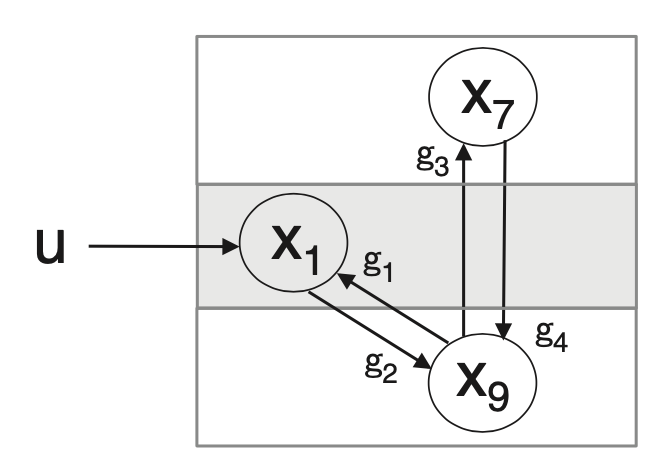

In [11]:
from IPython.display import Image
Image(filename='../Images/model.png', width=400)

This ODE given by:




\begin{array}{l}
\frac{dx_{1}(t)}{dt} = x_{4}(t) \\
\frac{dx_{2}(t)}{dt} = x_{5}(t) \\
\frac{dx_{3}(t)}{dt} = x_{6}(t) \\
\frac{dx_{7}(t)}{dt}  = x_{8}(t) \\
\frac{dx_{4}(t)}{dt} = \frac{{h_{e}(g_{1}(\frac{1}{e^{-0.56x_{9}(t-\delta)}+1} - 0.5) + u)}}{{\tau_{e}}} - \frac{{x_{1}(t)}}{{\tau_{e}^{2}}} - \frac{{2x_{4}(t)}}{{\tau_{e}}} \\
\frac{dx_{5}(t)}{dt}  = \frac{{g_{2}(\frac{1}{e^{-0.56x_{1}(t-\delta)}+1} - 0.5)}}{{\tau_{e}}} - \frac{{x_{2}(t)}}{{\tau_{e}^{2}}} - \frac{{2x_{5}(t)}}{{\tau_{e}}} \\
\frac{dx_{6}(t)}{dt}  = \frac{{g_{4}(\frac{1}{e^{-0.56x_{7}(t-\delta)}+1} - 0.5)}}{{\tau_{i}}} - \frac{{x_{3}(t)}}{{\tau_{i}^{2}}} - \frac{{2x_{6}^{t}}}{{\tau_{i}}} \\
\frac{dx_{8}(t)}{dt}  = \frac{{g_{3}(\frac{1}{e^{-0.56x_{9}(t-\delta)}+1} - 0.5)}}{{\tau_{e}}} - \frac{{x_{7}(t)}}{{\tau_{e}^{2}}} - \frac{{2x_{8}(t)}}{{\tau_{e}}} \\
\frac{dx_{9}(t)}{dt}  = x_{5}(t) - x_{6}(t)
\end{array}



The state vector $X(t)=[x_1(t), ...x_9(t)]$ comprises the densities of activity of neural populations. Parameters $\boldsymbol{\theta}=[g_1, g_2, g_3, g_4, \delta,\tau_i, h_i, \tau_e, h_e, u ]$ are the unknowns that we wish to infer from experimental observations.

$x(0)$ represents the initial values of the states needed to solve the ODE and is fixed to zero for all variables.

The unknown model parameters represent the following:

* $g_1, g_2, g_3, g_4$ are connection strengths.
* $\delta$ is the intrinsic delay.
* $h_{e,i}$ represents the maximum amplitude of excitatory (e) and inhibitory (i) post-synaptic potentials.
* $\tau_{e, i}$ are the rate constants for excitatory and inhibitory synaptic inputs, respectively.
* $u$  represents the input to each neural population

In [12]:
g_1=0.42
g_2=0.76
g_3=0.15
g_4=0.16
delta=12.13
tau_e=5.77
h_i=27.87
tau_i=7.77
h_e=1.63
u=3.94

In [13]:
theta_true = np.array([g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u])
n_params = theta_true.shape[0]

In [14]:
my_var_names = ['g_1', 'g_2', 'g_3', 'g_4', 'delta', 'tau_i', 'h_i', 'tau_e', 'h_e', 'u']

In [15]:
sigma_true=0.1

In [16]:
c=-0.56
constants=np.array([c])

In [17]:

def Sigmodal(x1, x2, delta, c):
    S=(1./(1.+np.exp(c*(x1-(delta*x2)))))-0.5
    return S

## Simulate with Pytensor Scan

We write the system of ODEs as a forward simulation solver within PyMC. The way to write for-loops in PyMC is with `pytensor.scan.` Gradients are then supplied to the sampler via autodifferentiation.    

In [18]:
t0=0.0
tend = 200.0
dt=0.1
ts = np.arange(t0, tend + dt, dt)

In [19]:
n_time=ts.shape[0]
n_states=9
n_time, n_states
ds=10

In [20]:
n_steps=int(n_time)

In [21]:
x_init_float64 = []
for _ in range(n_states):
    x_init_float64.append(np.float64(0.0))

In [22]:
# forward simulation model using scan
def model_scan_simulation(theta):
    # PyMC model
    with pm.Model() as model:
            # Priors (these are static for testing)
            g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u  =theta[0], theta[1], theta[2], theta[3], theta[4], theta[5], theta[6], theta[7], theta[8], theta[9],  

            def ode_update_function(x0, x1, x2, x3, x4, x5, x6, x7, x8, g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u ):
                    dx0=x3
                    dx1=x4
                    dx2=x5
                    dx6=x7
                    dx3=(1./tau_e)*(h_e*(g_1*(Sigmodal(x8, x4-x5, delta, c))+u)-(x0/tau_e)-2*x3)
                    dx4=(1./tau_e)*(h_e*(g_2*(Sigmodal(x0, x3, delta, c)))-(x1/tau_e)-2*x4)
                    dx5=(1./tau_i)*(h_i*(g_4*(Sigmodal(x6, x7, delta, c)))-(x2/tau_i)-2*x5)
                    dx7=(1./tau_e)*(h_e*(g_3*(Sigmodal(x8, x4-x5, delta, c)))-(x6/tau_e)-2*x7)
                    dx8=x4-x5

                    x0_new = x0 + dt * dx0 
                    x1_new = x1 + dt * dx1 
                    x2_new = x2 + dt * dx2 
                    x3_new = x3 + dt * dx3 
                    x4_new = x4 + dt * dx4 
                    x5_new = x5 + dt * dx5 
                    x6_new = x6 + dt * dx6 
                    x7_new = x7 + dt * dx7 
                    x8_new = x8 + dt * dx8 

                    return x0_new, x1_new, x2_new, x3_new, x4_new, x5_new, x6_new, x7_new, x8_new
        
            # Pytensor scan looping function
            result, updates = pytensor.scan(
                fn=ode_update_function,  
                outputs_info=x_init_float64,  
                non_sequences=[g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u ], 
                n_steps=n_steps, )

            # Put the results together and track the result
            pm.Deterministic("result", pm.math.stack([result[8]], axis=1))

    return model

Run the simulation for various time steps and plot the results.   

In [23]:
model_scan_simulation(theta_true)

result ~ Deterministic(f())

Sampling: []


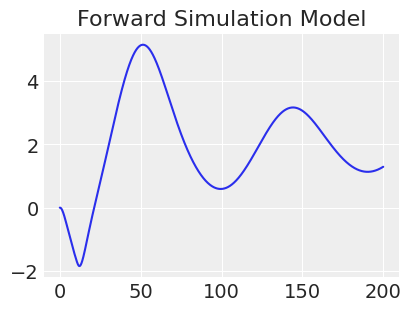

In [24]:
fig, ax = plt.subplots(figsize=(4, 3))
model = model_scan_simulation(theta_true)
with model:
    simul = pm.sample_prior_predictive(1).prior.result[0][0].values
    ax.plot(ts, simul)
ax.set_title("Forward Simulation Model");

## Generate observations

with additive noise

In [25]:
ts_obs=ts[::ds]
xpy_ds=simul[::ds].flatten()

In [26]:
x_noise = np.random.normal(loc=0, scale=sigma_true, size=xpy_ds.shape[0])
xpy_obs = xpy_ds + x_noise

In [27]:
# fmt: off
data = pd.DataFrame(dict(
    ts_obs = ts_obs,
    xpy_obs = xpy_obs, ds=ds))
data.head()
# fmt: on

,ts_obs,xpy_obs,ds
0,0.0,0.017419,10
1,1.0,0.074010,10
2,2.0,-0.207205,10
3,3.0,-0.410364,10
4,4.0,-0.426697,10


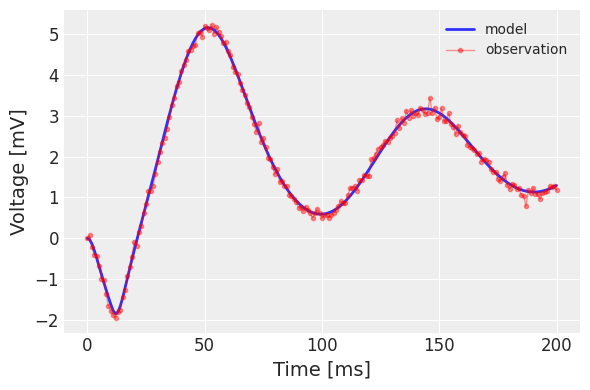

In [28]:
plot_observation(ts_obs, xpy_ds, ts_obs, xpy_obs);

## Prior

Since all the parameters are positive, we place Gamma prior, according to Refs [3,4].

In [29]:
shape=[18.16, 29.9, 29.14, 30.77, 22.87, 34.67, 20.44, 33.02, 24.17, 23.62]
scale=[0.03, 0.02, 0.005, 0.007, 0.51, 0.23, 0.96, 0.16, 0.07, 0.13]
rate = 1. / np.array(scale)

In [30]:
prior_specs = dict(shape=shape, rate=rate)

## Model with Pytensor Scan

In [31]:
def model_scan_inference(data, prior_specs):

    # PyMC model
    with pm.Model() as model:
        # Priors
        g_1 = pm.Gamma("g_1", alpha=prior_specs['shape'][0], beta=prior_specs['rate'][0])
        g_2 = pm.Gamma("g_2", alpha=prior_specs['shape'][1], beta=prior_specs['rate'][1])
        g_3 = pm.Gamma("g_3", alpha=prior_specs['shape'][2], beta=prior_specs['rate'][2])
        g_4 = pm.Gamma("g_4", alpha=prior_specs['shape'][3], beta=prior_specs['rate'][3])
        delta = pm.Gamma("delta", alpha=prior_specs['shape'][4], beta=prior_specs['rate'][4])
        tau_i = pm.Gamma("tau_i", alpha=prior_specs['shape'][5], beta=prior_specs['rate'][5])
        h_i = pm.Gamma("h_i", alpha=prior_specs['shape'][6], beta=prior_specs['rate'][6])
        tau_e = pm.Gamma("tau_e", alpha=prior_specs['shape'][7], beta=prior_specs['rate'][7])
        h_e = pm.Gamma("h_e", alpha=prior_specs['shape'][8], beta=prior_specs['rate'][8])
        u = pm.Gamma("u", alpha=prior_specs['shape'][9], beta=prior_specs['rate'][9])

        def ode_update_function(x0, x1, x2, x3, x4, x5, x6, x7, x8, g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u ):

                    dx0=x3
                    dx1=x4
                    dx2=x5
                    dx6=x7
                    dx3=(1./tau_e)*(h_e*(g_1*(Sigmodal(x8, x4-x5, delta, c))+u)-(x0/tau_e)-2*x3)
                    dx4=(1./tau_e)*(h_e*(g_2*(Sigmodal(x0, x3, delta, c)))-(x1/tau_e)-2*x4)
                    dx5=(1./tau_i)*(h_i*(g_4*(Sigmodal(x6, x7, delta, c)))-(x2/tau_i)-2*x5)
                    dx7=(1./tau_e)*(h_e*(g_3*(Sigmodal(x8, x4-x5, delta, c)))-(x6/tau_e)-2*x7)
                    dx8=x4-x5

                    x0_new = x0 + dt * dx0 
                    x1_new = x1 + dt * dx1 
                    x2_new = x2 + dt * dx2 
                    x3_new = x3 + dt * dx3 
                    x4_new = x4 + dt * dx4 
                    x5_new = x5 + dt * dx5 
                    x6_new = x6 + dt * dx6 
                    x7_new = x7 + dt * dx7 
                    x8_new = x8 + dt * dx8 

                    return x0_new, x1_new, x2_new, x3_new, x4_new, x5_new, x6_new, x7_new, x8_new
                
                
        result, updates = pytensor.scan(
                fn=ode_update_function,  
                outputs_info=x_init_float64,  
                non_sequences=[g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u ],  
                n_steps=n_steps, )

        final_result = pm.math.stack([result[8]], axis=1)
        
        xpy_model = pm.Deterministic("xpy_model", final_result[::ds])

        # Likelihood function
        pm.Normal("xpy_obs", mu=xpy_model, sigma=sigma_true, observed=data[["xpy_obs"]].values)
    return model

In [32]:
model = model_scan_inference(data, prior_specs)

## Prior Predictive Check

In [33]:
n_ = 100
with model :
    prior_pred = pm.sample_prior_predictive(samples=n_)

Sampling: [delta, g_1, g_2, g_3, g_4, h_e, h_i, tau_e, tau_i, u, xpy_obs]


In [34]:
prior_predictions = {'xpy_model': az.extract(prior_pred.prior['xpy_model']).to_array().values.squeeze().T}

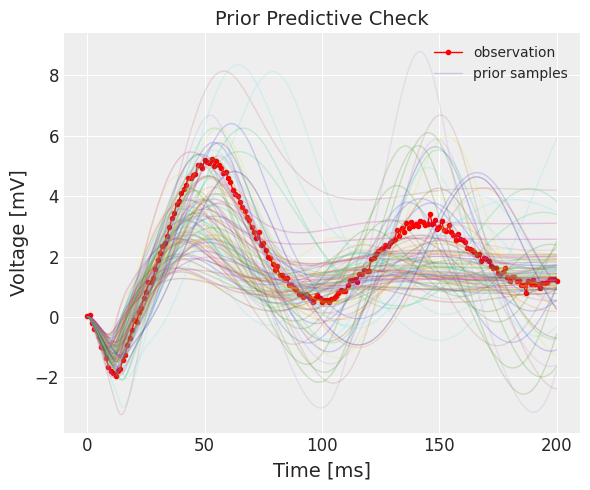

In [35]:
title='Prior Predictive Check'
plot_priorcheck(ts_obs, xpy_obs, prior_predictions, n_, title);

## NUTS sampling from pymc with blackjax sampler

In [36]:
tune, draws, n_chains = 200, 200, 4

In [37]:
start_time = time.time()
with model:
    trace_nuts_pytensor_scan_blackjax = pm.sample(nuts_sampler="blackjax", 
                                                  tune=tune, 
                                                  draws=draws, 
                                                  chains=n_chains,
                                                  target_accept=0.8,
                                                  progressbar=False)
crudetime_nuts_pytensor_scan_blackjax = time.time() - start_time
print("---running took: %s seconds ---" % crudetime_nuts_pytensor_scan_blackjax)

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


---running took: 75.32851910591125 seconds ---


In [38]:
az_obj = trace_nuts_pytensor_scan_blackjax

In [39]:
az.summary(az_obj, var_names=my_var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
g_1,0.507,0.119,0.299,0.730,0.005,0.003,616.0,599.0,1.00
g_2,0.637,0.074,0.495,0.766,0.003,0.003,469.0,364.0,1.01
g_3,0.142,0.024,0.096,0.187,0.001,0.001,775.0,429.0,1.01
g_4,0.211,0.032,0.154,0.268,0.001,0.001,614.0,488.0,1.00
delta,12.749,0.354,12.172,13.478,0.016,0.011,517.0,499.0,1.00
tau_i,7.591,0.082,7.439,7.750,0.003,0.002,770.0,642.0,1.00
h_i,19.306,3.405,13.294,25.991,0.150,0.110,533.0,398.0,1.01
tau_e,5.531,0.142,5.264,5.785,0.006,0.004,507.0,558.0,1.00
h_e,2.008,0.230,1.558,2.405,0.011,0.007,477.0,399.0,1.01
u,3.707,0.606,2.718,4.946,0.023,0.017,777.0,471.0,1.00


## Posterior

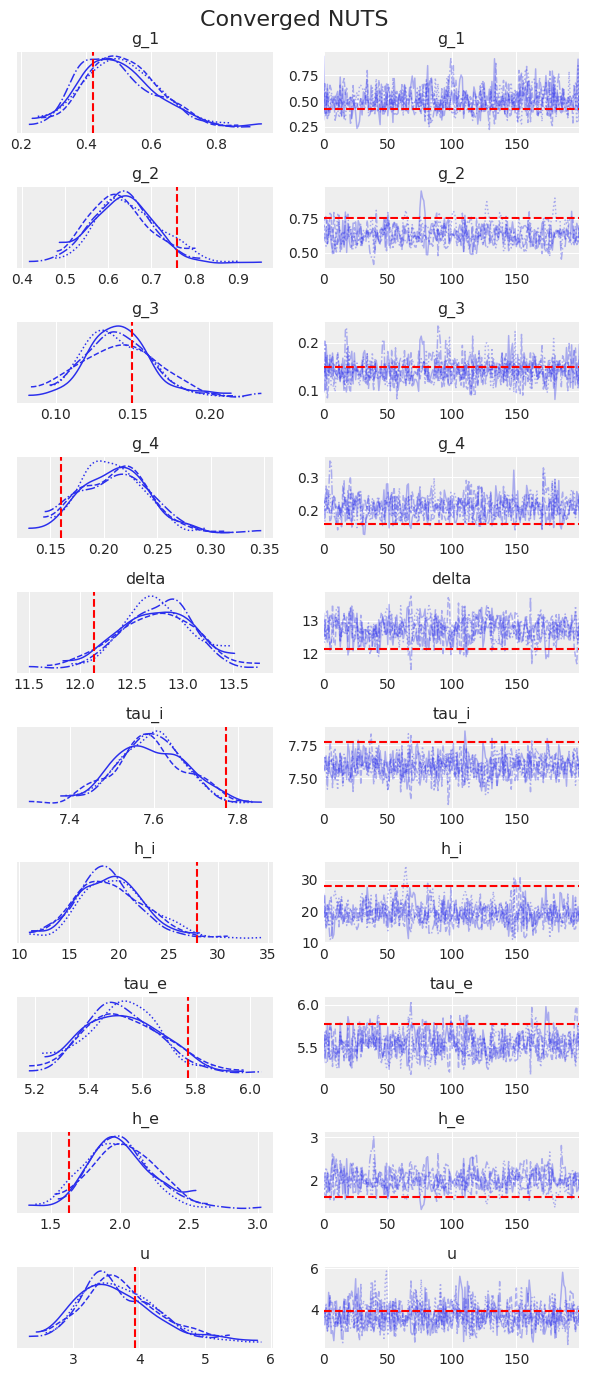

In [40]:
axes = az.plot_trace(
    az_obj,
    var_names=my_var_names,
    compact=True,
    kind="trace",
    backend_kwargs={"figsize": (6, 14), "layout": "constrained"},)

for ax, true_val in zip(axes[:, 0], theta_true):
    ax.axvline(x=true_val, color='red', linestyle='--')  
for ax, true_val in zip(axes[:, 1], theta_true):
    ax.axhline(y=true_val, color='red', linestyle='--')
    
plt.gcf().suptitle("Converged NUTS", fontsize=16)
plt.tight_layout();

## Fit and Posterior predictive check

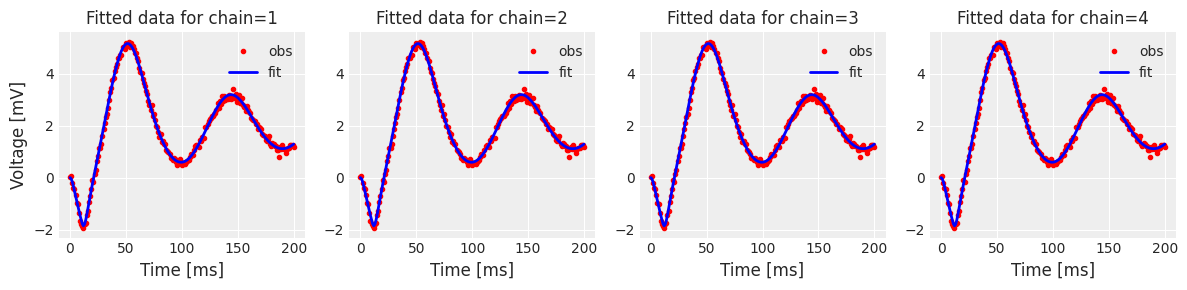

In [42]:
plot_fitted(data, az_obj.posterior);

In [43]:
n_ = 100
with model :
    post_pred = pm.sample_posterior_predictive(trace=az_obj, var_names=['xpy_model', 'xpy_obs'])

Sampling: [xpy_obs]


In [44]:
ppc_ = az.extract(post_pred.posterior_predictive['xpy_obs']).to_array().values.squeeze().T
xpy_per05_pooled=np.quantile(ppc_, 0.05, axis=0)
xpy_per95_pooled=np.quantile(ppc_, 0.95, axis=0)

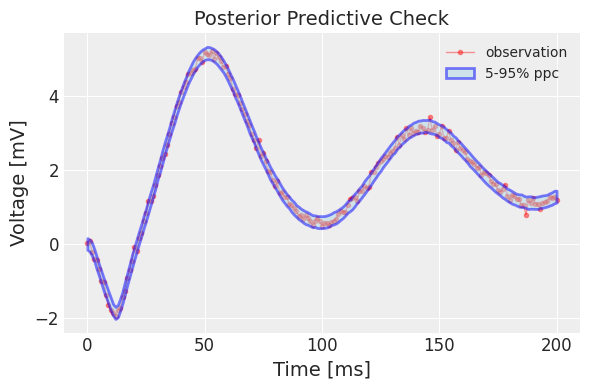

In [45]:
title='Posterior Predictive Check'
plot_posteriorcheck(data, xpy_per05_pooled, xpy_per95_pooled, title);

In [46]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu May 02 2024

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.24.0

pymc      : 5.11.0
blackjax  : 1.1.1
seaborn   : 0.13.2
pandas    : 2.2.2
numpy     : 1.26.0
pytensor  : 2.18.6
matplotlib: 3.8.4
sys       : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
arviz     : 0.18.0

Watermark: 2.4.3



In [ ]:
#Better install pymc on virtual env to avoid conflicts with existing packages
#create virtual environment
#! python3 -m venv .pymc_env 

#in local repository:
#run: 
#source .pymc_env/bin/activate
#then
#pip install ipykernel
#ipython kernel install --user --name=projectname
#pip install rpy2

#open notebook with environment activated and choose kernel pymc_env
#check that it points to the environment:

In [ ]:
#! which python3